## Analisi delle sintesi
Clustering gaussiano

In [2]:
import numpy as np
from sklearn.mixture import GaussianMixture

In [3]:
# carico i dati di una sintesi
synth_path = r'../data/out/synth/AnalMat2-1.pgm'
with open(synth_path, 'rb') as f:
    data = np.fromfile(f, dtype=np.uint8)

data = data.reshape(-1, 36).astype(np.float32)
print(len(data))

2133550


In [4]:
# eseguo il Gaussian Mixture Model
n_clusters = 16
gmm = GaussianMixture(n_components=n_clusters, covariance_type='full', init_params='kmeans', max_iter=1000)

gmm.fit(data)

In [14]:
# qualità di clusterizzazione

print('BIC:', gmm.bic(data))
print('AIC:', gmm.aic(data))

BIC: -919708542.8638506
AIC: -919938345.028052


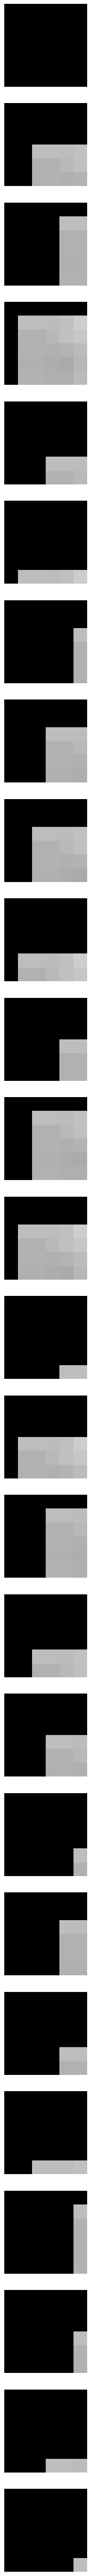

In [15]:
# plot dei centroidi individuati
import matplotlib.pyplot as plt

fig, ax = plt.subplots(n_clusters, 1, figsize=(3, 3 * n_clusters))
for i in range(n_clusters):
    ax[i].imshow(gmm.means_[i].reshape(6, 6), cmap='gray', vmin=0, vmax=255, interpolation='none')
    ax[i].axis('off')

In [21]:
# esaminiamo il cluster 0
print('Peso:', gmm.weights_[0])
print('Mean:', gmm.means_[0])
print('Covariance:', gmm.covariances_[0])

# mostro i valori labelati con il cluster 0
labels = gmm.predict(data)
cluster0 = data[labels == 0]
print(cluster0)

Peso: 0.9999882824400647
Mean: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Covariance: [[1.e-06 0.e+00 0.e+00 ... 0.e+00 0.e+00 0.e+00]
 [0.e+00 1.e-06 0.e+00 ... 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 1.e-06 ... 0.e+00 0.e+00 0.e+00]
 ...
 [0.e+00 0.e+00 0.e+00 ... 1.e-06 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 ... 0.e+00 1.e-06 0.e+00]
 [0.e+00 0.e+00 0.e+00 ... 0.e+00 0.e+00 1.e-06]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
